In [2]:
!pip install rdkit
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost
!pip install joblib

   ---------------------------------------- 0.0/22.5 MB ? eta -:--:--
   --- ------------------------------------ 2.1/22.5 MB 14.7 MB/s eta 0:00:02
   --------- ------------------------------ 5.5/22.5 MB 14.0 MB/s eta 0:00:02
   -------------- ------------------------- 8.1/22.5 MB 13.6 MB/s eta 0:00:02
   ------------------ --------------------- 10.5/22.5 MB 13.3 MB/s eta 0:00:01
   ---------------------- ----------------- 12.6/22.5 MB 13.1 MB/s eta 0:00:01
   -------------------------- ------------- 14.9/22.5 MB 12.2 MB/s eta 0:00:01
   ------------------------------- -------- 17.8/22.5 MB 12.5 MB/s eta 0:00:01
   ----------------------------------- ---- 19.9/22.5 MB 12.5 MB/s eta 0:00:01
   ---------------------------------------- 22.5/22.5 MB 12.4 MB/s eta 0:00:00
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 0.0/11.2 MB ? eta -:--:--
   ------------------- -------------------- 5.5/11.2 MB 30.5 MB/s eta 0:00:01
   --------

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from xgboost import XGBRegressor
import joblib
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

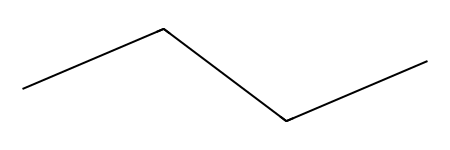

In [5]:
mol = Chem.MolFromSmiles('CCCC')
mol

In [ ]:
#!/usr/bin/env python
import pandas as pd
import numpy as np

# RDKit for SMILES parsing
from rdkit import Chem
from rdkit.Chem import AllChem

# For train-test split, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# (Optional) Feature scaling
from sklearn.preprocessing import StandardScaler

# XGBoost
# pip install xgboost
import xgboost as xgb

def smiles_to_morgan_fp(smi, radius=2, n_bits=256):
    """
    Convert a SMILES string to a Morgan fingerprint (ECFP) vector of length n_bits.
    Returns a NumPy array of shape (n_bits,) or None if the SMILES is invalid.

    We use 256 bits (instead of 1024) to reduce dimensionality for this small dataset.
    """
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    for i in range(n_bits):
        if fp.GetBit(i):
            arr[i] = 1
    return arr

def main():
    # 1. Load your CSV dataset (adjust filename/column names as needed)
    file_path = 'C:/Users/gagno/Downloads/molecule_dataset.csv'
    df = pd.read_csv(file_path)
    print(df.head(18))  # CSV should include 'SMILES', 'enhancement_factor', and 16 descriptor columns
    
    # 2. Basic cleaning: handle infinities and ensure 'Enhancement Factor' is numeric
    df = df.replace([np.inf, -np.inf], np.nan)
    df["Enhancement Factor"] = pd.to_numeric(df["Enhancement Factor"], errors='coerce')
    
    # Drop rows with missing values in critical columns
    df.dropna(subset=["Smiles", "Enhancement Factor"], inplace=True)
    
    # 3. Convert SMILES to numeric features (Morgan fingerprints)
    smiles_list = df["Smiles"].astype(str).tolist()
    enhancement_factors = df["Enhancement Factor"].values
    
    X_fps = []
    valid_y = []
    for smi, val in zip(smiles_list, enhancement_factors):
        fp = smiles_to_morgan_fp(smi, radius=2, n_bits=256)
        if fp is not None:
            X_fps.append(fp)
            valid_y.append(val)
    X = np.array(X_fps, dtype=float)
    y = np.array(valid_y, dtype=float)
    
    # 4. Train-test split
    #    We'll do 80-20, but with only 16 rows, cross-validation is recommended for a better estimate.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # 5. (Optional) Feature scaling
    #    XGBoost often handles unscaled data well, but scaling can help if you have extra numeric descriptors.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # 6. Define and train an XGBoost regressor
    #    Adjust n_estimators, max_depth, learning_rate, etc. via cross-validation if possible.
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        verbosity=0  # suppress training logs
    )
    model.fit(X_train_scaled, y_train)
    
    # 7. Evaluate on the test set
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Adjusted R² = 1 - (1 - R²)*(n - 1)/(n - p - 1)
    n = len(y_test)
    p = X_test_scaled.shape[1]  # e.g., 256 if not reduced further
    if n > p + 1:
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adjusted_r2 = float('nan')  # Not well-defined if p >= n-1
    
    print("\n=== XGBoost Model (Test Set) ===")
    print("n_estimators=100, max_depth=3, learning_rate=0.1")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"Adjusted R²: {adjusted_r2:.4f}")

    # 8. (Optional) Retrain a final model on the entire dataset for new SMILES predictions
    final_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    )
    # Scale the entire dataset
    X_scaled = scaler.fit_transform(X)  # re-fit on all data
    final_model.fit(X_scaled, y)
    
    # 9. Interactive input for new SMILES outside the dataset
    print("\n=== Predict Enhancement Factor for a new SMILES ===")
    while True:
        user_input = input("Enter a SMILES string (or type 'quit' to exit): ").strip()
        if user_input.lower() == 'quit':
            print("Exiting.")
            break
        
        new_fp = smiles_to_morgan_fp(user_input, radius=2, n_bits=256)
        if new_fp is None:
            print("Invalid SMILES entered. Please try again.\n")
            continue
        
        # Scale the new fingerprint
        new_fp_scaled = scaler.transform([new_fp])
        pred_val = final_model.predict(new_fp_scaled)[0]
        print(f"Predicted Enhancement Factor: {pred_val:.4f}\n")

if __name__ == "__main__":
    main()


Here is an improved version of model

-
-
-
-
-
-
-
-
-
-


In [6]:
#!/usr/bin/env python
import pandas as pd
import numpy as np

# RDKit for SMILES parsing
from rdkit import Chem
from rdkit.Chem import AllChem

# For train-test split, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# (Optional) Feature scaling
from sklearn.preprocessing import StandardScaler

# XGBoost
# pip install xgboost
import xgboost as xgb

def smiles_to_morgan_fp(smi, radius=2, n_bits=256):
    """
    Convert a SMILES string to a Morgan fingerprint (ECFP) vector of length n_bits.
    Returns a NumPy array of shape (n_bits,) or None if the SMILES is invalid.

    We use 256 bits (instead of 1024) to reduce dimensionality for a small dataset.
    """
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    for i in range(n_bits):
        if fp.GetBit(i):
            arr[i] = 1
    return arr

def main():
    # 1. Load your CSV dataset
    file_path = 'C:/Users/gagno/Downloads/molecule_dataset.csv'
    df = pd.read_csv(file_path)
    print(df.head(18))  # Quick peek at data
    
    # 2. Basic cleaning
    df = df.replace([np.inf, -np.inf], np.nan)
    df["Enhancement Factor"] = pd.to_numeric(df["Enhancement Factor"], errors='coerce')
    df.dropna(subset=["Smiles", "Enhancement Factor"], inplace=True)
    
    # 3. Convert SMILES to numeric features (256-bit Morgan fingerprints)
    smiles_list = df["Smiles"].astype(str).tolist()
    enhancement_factors = df["Enhancement Factor"].values
    
    X_fps = []
    valid_y = []
    for smi, val in zip(smiles_list, enhancement_factors):
        fp = smiles_to_morgan_fp(smi, radius=2, n_bits=256)
        if fp is not None:
            X_fps.append(fp)
            valid_y.append(val)
    X = np.array(X_fps, dtype=float)
    y = np.array(valid_y, dtype=float)
    
    # --- NEW: Log-Transform the Enhancement Factor ---
    # If EF is always > 0, np.log1p helps handle large numeric ranges or outliers.
    y_log = np.log1p(y)  # log(1 + EF)
    
    # 4. Train-test split (80-20)
    X_train, X_test, y_train_log, y_test_log = train_test_split(
        X, y_log, test_size=0.2, random_state=42
    )
    
    # 5. (Optional) Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # 6. Define and train an XGBoost regressor
    #    We'll keep the same hyperparameters but train on y_train_log
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    )
    model.fit(X_train_scaled, y_train_log)
    
    # 7. Evaluate on the test set
    #    Predictions are in log space, so exponentiate back
    y_pred_log = model.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)  # revert from log(EF) to EF
    
    # Convert y_test_log back for metrics
    y_test = np.expm1(y_test_log)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Adjusted R²
    n = len(y_test)
    p = X_test_scaled.shape[1]
    if n > p + 1:
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adjusted_r2 = float('nan')
    
    print("\n=== XGBoost Model (Test Set) ===")
    print("Log-transform of Enhancement Factor + 256-bit fingerprints")
    print("n_estimators=100, max_depth=3, learning_rate=0.1")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"Adjusted R²: {adjusted_r2:.4f}")

    # 8. (Optional) Retrain a final model on the entire dataset for new SMILES predictions
    final_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    )
    # Scale the entire dataset
    X_scaled = scaler.fit_transform(X)
    y_log_all = np.log1p(y)
    final_model.fit(X_scaled, y_log_all)
    
    # 9. Interactive input for new SMILES outside the dataset
    print("\n=== Predict Enhancement Factor for a new SMILES ===")
    while True:
        user_input = input("Enter a SMILES string (or type 'quit' to exit): ").strip()
        if user_input.lower() == 'quit':
            print("Exiting.")
            break
        
        new_fp = smiles_to_morgan_fp(user_input, radius=2, n_bits=256)
        if new_fp is None:
            print("Invalid SMILES entered. Please try again.\n")
            continue
        
        # Scale the new fingerprint
        new_fp_scaled = scaler.transform([new_fp])
        # Predict in log space, then exponentiate
        pred_log = final_model.predict(new_fp_scaled)[0]
        pred_val = np.expm1(pred_log)
        print(f"Predicted Enhancement Factor: {pred_val:.4f}\n")

if __name__ == "__main__":
    main()


    ID                         Name  \
0     1         Ibuprofen / HP-B-CD   
1     2      Dexamethasone / B - CD   
2     3         Piroxicam / HP-B-CD   
3     4    Hydrocortisone / HP-B-CD   
4     5       Albendazole / RM-B-CD   
5     6            Valtarsan / B-CD   
6     7        Nifedipine / HP-B-CD   
7     8        Nimodipine / HP-B-CD   
8     9     Carbamazepine / HP-B-CD   
9    10      Itraconazole / HP-B-CD   
10   11       Simvastatin / HP-B-CD   
11   12          Curcumin / HP-B-CD   
12   13  Indomethacin / HP- B - CD    
13   14     Naproxen / HP - B - CD    
14   15        Diclofenac / HP-B-CD   
15   16   Resveratrol / HP-Gamma CD   
16   17              Amphotericin B   
17   18                 Budesonide    

                                               Smiles MolWeight  LogP  \
0                          CC(C)Cc1ccc(cc1)C(C)C(=O)O   1606.29  3.84   
1   CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...   1527.47  1.93   
2                     CN1NS(=O)(=O)C2=C

[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerator
[02:07:36] DEPRECATION WARNING: please use MorganGenerat


=== Predict Enhancement Factor for a new SMILES ===


Enter a SMILES string (or type 'quit' to exit):  quit


Exiting.


Now, we do an analysis for both validation and test set of model:
    -
    -
    -
    -
    -
    -
    -
    -
    -
    -
    

In [ ]:
#!/usr/bin/env python
import pandas as pd
import numpy as np

# RDKit for SMILES parsing
from rdkit import Chem
from rdkit.Chem import AllChem

# For train-test split, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# (Optional) Feature scaling
from sklearn.preprocessing import StandardScaler

# XGBoost
# pip install xgboost
import xgboost as xgb

def smiles_to_morgan_fp(smi, radius=2, n_bits=256):
    """
    Convert a SMILES string to a Morgan fingerprint (ECFP) vector of length n_bits.
    Returns a NumPy array of shape (n_bits,) or None if the SMILES is invalid.

    We use 256 bits (instead of 1024) to reduce dimensionality for a small dataset.
    """
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    for i in range(n_bits):
        if fp.GetBit(i):
            arr[i] = 1
    return arr

def main():
    # 1. Load your CSV dataset
    file_path = 'C:/Users/gagno/Downloads/molecule_dataset.csv'
    df = pd.read_csv(file_path)
    print(df.head(18))  # Quick peek at data
    
    # 2. Basic cleaning
    df = df.replace([np.inf, -np.inf], np.nan)
    df["Enhancement Factor"] = pd.to_numeric(df["Enhancement Factor"], errors='coerce')
    df.dropna(subset=["Smiles", "Enhancement Factor"], inplace=True)
    
    # 3. Convert SMILES to numeric features (256-bit Morgan fingerprints)
    smiles_list = df["Smiles"].astype(str).tolist()
    enhancement_factors = df["Enhancement Factor"].values
    
    X_fps = []
    valid_y = []
    for smi, val in zip(smiles_list, enhancement_factors):
        fp = smiles_to_morgan_fp(smi, radius=2, n_bits=256)
        if fp is not None:
            X_fps.append(fp)
            valid_y.append(val)
    X = np.array(X_fps, dtype=float)
    y = np.array(valid_y, dtype=float)
    
    # --- Log-Transform the Enhancement Factor ---
    # If EF is always > 0, np.log1p helps handle large numeric ranges or outliers.
    y_log = np.log1p(y)  # log(1 + EF)
    
    # 4. Three-way split: Train (60%), Validation (20%), Test (20%)
    # First, split off 20% for test
    X_temp, X_test, y_temp_log, y_test_log = train_test_split(
        X, y_log, test_size=0.2, random_state=42
    )
    # Then, from the remaining 80%, split 25% (which is 0.25*80%=20% overall) for validation
    X_train, X_val, y_train_log, y_val_log = train_test_split(
        X_temp, y_temp_log, test_size=0.25, random_state=42
    )
    # Now we have: 60% train, 20% val, 20% test
    
    # 5. (Optional) Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)
    
    # 6. Define and train an XGBoost regressor on the TRAIN set
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    )
    model.fit(X_train_scaled, y_train_log)
    
    # 7. Evaluate on the VALIDATION set
    y_val_pred_log = model.predict(X_val_scaled)
    y_val_pred = np.expm1(y_val_pred_log)  # revert from log(EF) to EF
    y_val = np.expm1(y_val_log)
    
    mse_val  = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    mae_val  = mean_absolute_error(y_val, y_val_pred)
    r2_val   = r2_score(y_val, y_val_pred)
    
    # Adjusted R² on validation
    n_val = len(y_val)
    p_val = X_val_scaled.shape[1]
    if n_val > p_val + 1:
        adj_r2_val = 1 - (1 - r2_val) * (n_val - 1) / (n_val - p_val - 1)
    else:
        adj_r2_val = float('nan')
    
    print("\n=== XGBoost Model (Validation Set) ===")
    print("Log-transform of Enhancement Factor + 256-bit fingerprints")
    print("n_estimators=100, max_depth=3, learning_rate=0.1")
    print(f"MSE  : {mse_val:.4f}")
    print(f"RMSE : {rmse_val:.4f}")
    print(f"MAE  : {mae_val:.4f}")
    print(f"R²   : {r2_val:.4f}")
    print(f"Adjusted R²: {adj_r2_val:.4f}")
    
    # 8. Evaluate on the TEST set
    y_test_pred_log = model.predict(X_test_scaled)
    y_test_pred = np.expm1(y_test_pred_log)
    y_test_orig = np.expm1(y_test_log)
    
    mse_test  = mean_squared_error(y_test_orig, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test  = mean_absolute_error(y_test_orig, y_test_pred)
    r2_test   = r2_score(y_test_orig, y_test_pred)
    
    # Adjusted R² on test
    n_test = len(y_test_orig)
    p_test = X_test_scaled.shape[1]
    if n_test > p_test + 1:
        adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)
    else:
        adj_r2_test = float('nan')
    
    print("\n=== XGBoost Model (Test Set) ===")
    print("Log-transform of Enhancement Factor + 256-bit fingerprints")
    print("n_estimators=100, max_depth=3, learning_rate=0.1")
    print(f"MSE  : {mse_test:.4f}")
    print(f"RMSE : {rmse_test:.4f}")
    print(f"MAE  : {mae_test:.4f}")
    print(f"R²   : {r2_test:.4f}")
    print(f"Adjusted R²: {adj_r2_test:.4f}")
    
    # 9. (Optional) If you want to re-train on the entire dataset for new SMILES predictions,
    #    you can do so here. We'll skip that step in favor of the train/val/test approach.

    # 10. Interactive input for new SMILES outside the dataset
    print("\n=== Predict Enhancement Factor for a new SMILES ===")
    while True:
        user_input = input("Enter a SMILES string (or type 'quit' to exit): ").strip()
        if user_input.lower() == 'quit':
            print("Exiting.")
            break
        
        new_fp = smiles_to_morgan_fp(user_input, radius=2, n_bits=256)
        if new_fp is None:
            print("Invalid SMILES entered. Please try again.\n")
            continue
        
        # Scale the new fingerprint
        new_fp_scaled = scaler.transform([new_fp])
        # Predict in log space, then exponentiate
        pred_log = model.predict(new_fp_scaled)[0]
        pred_val = np.expm1(pred_log)
        print(f"Predicted Enhancement Factor: {pred_val:.4f}\n")

if __name__ == "__main__":
    main()


    ID                         Name  \
0     1         Ibuprofen / HP-B-CD   
1     2      Dexamethasone / B - CD   
2     3         Piroxicam / HP-B-CD   
3     4    Hydrocortisone / HP-B-CD   
4     5       Albendazole / RM-B-CD   
5     6            Valtarsan / B-CD   
6     7        Nifedipine / HP-B-CD   
7     8        Nimodipine / HP-B-CD   
8     9     Carbamazepine / HP-B-CD   
9    10      Itraconazole / HP-B-CD   
10   11       Simvastatin / HP-B-CD   
11   12          Curcumin / HP-B-CD   
12   13  Indomethacin / HP- B - CD    
13   14     Naproxen / HP - B - CD    
14   15        Diclofenac / HP-B-CD   
15   16   Resveratrol / HP-Gamma CD   
16   17              Amphotericin B   
17   18                 Budesonide    

                                               Smiles MolWeight  LogP  \
0                          CC(C)Cc1ccc(cc1)C(C)C(=O)O   1606.29  3.84   
1   CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...   1527.47  1.93   
2                     CN1NS(=O)(=O)C2=C

[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerator
[01:41:08] DEPRECATION WARNING: please use MorganGenerat


=== XGBoost Model (Validation Set) ===
Log-transform of Enhancement Factor + 256-bit fingerprints
n_estimators=100, max_depth=3, learning_rate=0.1
MSE  : 26495375.0315
RMSE : 5147.3658
MAE  : 2174.1652
R²   : 0.0781
Adjusted R²: nan

=== XGBoost Model (Test Set) ===
Log-transform of Enhancement Factor + 256-bit fingerprints
n_estimators=100, max_depth=3, learning_rate=0.1
MSE  : 139428.4386
RMSE : 373.4012
MAE  : 161.2269
R²   : -0.1383
Adjusted R²: nan

=== Predict Enhancement Factor for a new SMILES ===


Now, we produce the website version of this model:
    =
    =
    =
    =
    =
    =
    =
    =
    =
    =
    =
    =-
    

In [1]:
#!/usr/bin/env python
import os
import numpy as np
import pandas as pd

from flask import Flask, request, render_template_string
from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

#############################################
# 1. Utility function for SMILES -> fingerprint
#############################################
def smiles_to_morgan_fp(smi, radius=2, n_bits=256):
    """
    Convert a SMILES string to a Morgan fingerprint (ECFP) vector of length n_bits.
    Returns a NumPy array of shape (n_bits,) or None if SMILES is invalid.

    Using 256 bits to reduce dimensionality.
    """
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    for i in range(n_bits):
        if fp.GetBit(i):
            arr[i] = 1
    return arr

#############################################
# 2. Create Flask app
#############################################
app = Flask(__name__)

#############################################
# 3. Train XGBoost model on startup
#############################################
@app.before_first_request
def train_model():
    global model, scaler, y_log_all
    
    # 3a. Load dataset
    file_path = 'C:/Users/gagno/Downloads/molecule_dataset.csv'  # Adjust path if needed
    df = pd.read_csv(file_path)
    # Basic cleaning
    df = df.replace([np.inf, -np.inf], np.nan)
    df["Enhancement Factor"] = pd.to_numeric(df["Enhancement Factor"], errors='coerce')
    df.dropna(subset=["Smiles", "Enhancement Factor"], inplace=True)
    
    # 3b. Convert SMILES -> 256-bit fingerprints
    smiles_list = df["Smiles"].astype(str).tolist()
    enhancement_factors = df["Enhancement Factor"].values
    
    X_fps = []
    valid_y = []
    for smi, val in zip(smiles_list, enhancement_factors):
        fp = smiles_to_morgan_fp(smi, radius=2, n_bits=256)
        if fp is not None:
            X_fps.append(fp)
            valid_y.append(val)
    X = np.array(X_fps, dtype=float)
    y = np.array(valid_y, dtype=float)
    
    # 3c. Log-transform the target
    y_log_all = np.log1p(y)
    
    # 3d. Scale features
    global X_scaled
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3e. Train XGBoost
    global final_model
    final_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    )
    final_model.fit(X_scaled, y_log_all)

#############################################
# 4. Define a simple HTML template
#############################################
HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Enhancement Factor Predictor</title>
  <!-- Basic Bootstrap for a decorated, interactive page -->
  <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css">
  <style>
    body {
      background: linear-gradient(to bottom right, #e3f2fd, #fff);
      font-family: 'Helvetica Neue', Arial, sans-serif;
      margin: 0; padding: 0;
    }
    .container {
      margin-top: 50px;
      max-width: 600px;
      background: #fefefe;
      border-radius: 10px;
      padding: 30px;
      box-shadow: 0 0 15px rgba(0,0,0,0.1);
    }
    h1 {
      text-align: center;
      margin-bottom: 30px;
    }
    .footer {
      margin-top: 30px;
      text-align: center;
      color: #777;
      font-size: 0.9em;
    }
  </style>
</head>
<body>
  <div class="container">
    <h1>Enhancement Factor Predictor</h1>
    <p class="text-secondary">
      Enter a SMILES string below. Our XGBoost model (log-transform + 256-bit Morgan fingerprints) 
      will predict the Enhancement Factor for your molecule.
    </p>
    <form method="POST" action="/predict">
      <div class="mb-3">
        <label for="smiles" class="form-label">SMILES:</label>
        <input type="text" class="form-control" id="smiles" name="smiles" placeholder="e.g. CC(=O)Oc1ccccc1C(=O)O" required>
      </div>
      <button type="submit" class="btn btn-primary">Predict</button>
    </form>
    {% if prediction %}
    <hr>
    <div class="alert alert-info mt-4" role="alert">
      <h4>Prediction</h4>
      <p><strong>SMILES:</strong> {{ smiles_input }}</p>
      <p><strong>Predicted Enhancement Factor:</strong> {{ prediction }}</p>
    </div>
    {% endif %}
  </div>
  <div class="footer">
    <p>Powered by XGBoost | <a href="https://github.com/">View on GitHub</a></p>
  </div>
</body>
</html>
"""

#############################################
# 5. Routes
#############################################
@app.route("/", methods=["GET"])
def index():
    # Just render the form
    return render_template_string(HTML_TEMPLATE)

@app.route("/predict", methods=["POST"])
def predict():
    # Retrieve the SMILES string from the form
    smiles_input = request.form.get("smiles", "").strip()
    
    # Convert to fingerprint
    fp = smiles_to_morgan_fp(smiles_input, radius=2, n_bits=256)
    if fp is None:
        # Invalid SMILES
        prediction = "Invalid SMILES entered. Please try again."
        return render_template_string(HTML_TEMPLATE, prediction=prediction, smiles_input=smiles_input)
    
    # Scale
    global scaler, final_model, y_log_all
    fp_scaled = scaler.transform([fp])
    
    # Predict in log space, then exponentiate
    pred_log = final_model.predict(fp_scaled)[0]
    pred_val = np.expm1(pred_log)
    prediction = f"{pred_val:.4f}"
    
    return render_template_string(HTML_TEMPLATE, prediction=prediction, smiles_input=smiles_input)

#############################################
# 6. Run Flask app
#############################################
if __name__ == "__main__":
    app.run(debug=True, use_reloader=False)


AttributeError: 'Flask' object has no attribute 'before_first_request'